# Learning to play Tic-Tac-Toe

Nous allons maintenant tenter d'utiliser un réseau neuronal pour apprendre les mouvements optimaux de Tic-Tac-Toe. Nous aborderons cette tâche en sachant que le Tic-Tac-Toe est un jeu déterministe et que les mouvements optimaux sont déjà connus.

Pour entraîner notre modèle, nous utiliserons une liste de positions de plateau suivie de la réponse optimale pour un certain nombre de plateaux différents. Nous pouvons réduire le nombre de planches sur lesquelles nous devons nous entraîner en ne considérant que les positions de planches qui sont différentes en termes de symétrie.

La première vérification que nous allons effectuer consiste à supprimer une position et une rangée de coups optimaux de notre ensemble de formation. Cela nous permettra de voir si le modèle de réseau neuronal peut généraliser un coup qu'il n'a jamais vu auparavant. La deuxième façon d'évaluer notre modèle est de jouer une partie contre lui à la fin de la partie.

# Import

In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import random 

# Sommaire

[I. Prepare Game](#Partie1) 

[II. Set-up, train and evaluate the neural network](#Partie2) 

[III. Play against the AI](#Partie3) 


## I. Prepare Game <a class="anchor" id="Partie1"></a>

In [53]:
def print_board(board):
    ''' 
    To make visualizing the boards a bit easier, 
    we will create a function that outputs 
    Tic-Tac-Toe boards with Xs and Os. 
    ''' 
    symbols = ['O', ' ', 'X']
    board_plus1 = [int(x) + 1 for x in board]
    board_line1 = ' {} | {} | {}'.format(symbols[board_plus1[0]],symbols[board_plus1[1]],symbols[board_plus1[2]])
    board_line2  = ' {} | {} | {}'.format(symbols[board_plus1[3]],symbols[board_plus1[4]],symbols[board_plus1[5]])
    board_line3  = ' {} | {} | {}'.format(symbols[board_plus1[6]],symbols[board_plus1[7]],symbols[board_plus1[8]])
    print(board_line1)    
    print('___________')    
    print(board_line2)
    print('___________')    
    print(board_line3)

In [54]:
print_board([-1,1,1,-1,1,-1,1,-1,1])

 O | X | X
___________
 O | X | O
___________
 X | O | X


In [55]:
def get_symmetry(board, response, transformation):     
    '''     
    Now we have to create a function that will return a 
    new board and an optimal response position under a transformation. 

    param board: list of integers 9 long:      
    opposing mark = -1      
    friendly mark = 1      
    empty space = 0     
    
    param transformation: one of five transformations on a                                             
    board:rotate180, rotate90, rotate270, flip_v, flip_h     
    
    return: tuple: (new_board, new_response)     
    '''      
    if transformation == 'rotate180':         
        new_response = 8 - response         
        return board[::-1], new_response      
    elif transformation == 'rotate90':         
        new_response = [6, 3, 0, 7, 4, 1, 8, 5, 2].index(response)         
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))         
        return [value for item in tuple_board for value in item], new_response      
    elif transformation == 'rotate270':         
        new_response = [2, 5, 8, 1, 4, 7, 0, 3, 6].index(response)         
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]         
        return [value for item in tuple_board for value in item], new_response      
    elif transformation == 'flip_v':         
        new_response = [6, 7, 8, 3, 4, 5, 0, 1, 2].index(response)         
        return board[6:9] +  board[3:6] + board[0:3], new_response      
    elif transformation == 'flip_h':     
        # flip_h = rotate180, then flip_v         
        new_response = [2, 1, 0, 5, 4, 3, 8, 7, 6].index(response)         
        new_board = board[::-1]         
        return new_board[6:9] +  new_board[3:6] + new_board[0:3], new_response
    else:         
        raise ValueError('Method not implmented.')

In [56]:
def get_moves_from_csv(csv_file): 
    ''' 
    Create a function that will load the file with the 
    boards and responses and will store it as a list of tuples

    :param csv_file: csv file location containing the boards and responses 
    :return: moves: list of moves with index of best response 
    ''' 
    moves = [] 
    with open(csv_file, 'rt') as csvfile: 
        reader = csv.reader(csvfile, delimiter=',') 
        for row in reader: 
            moves.append(([int(x) for x in row[0:9]],int(row[9]))) 
    return moves 


In [57]:
def get_rand_move(moves, rand_transforms=2): 
    # This function performs random transformations on a board. 
    (board, response) = random.choice(moves) 
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h'] 
    for i in range(rand_transforms): 
        random_transform = random.choice(possible_transforms) 
        (board, response) = get_symmetry(board, response, random_transform) 
    return board, response

In [58]:
# load our data and create a training se
moves = get_moves_from_csv('base_tic_tac_toe_moves.csv') 
# Create a train set: 
train_length = 500 
train_set = [] 
for t in range(train_length): 
    train_set.append(get_rand_move(moves)) 


In [59]:
'''
 remove one board and an optimal response 
 from our training set to see if the model can 
 generalize making the best move. 
 The best move for the following board will be to play at index number 6
'''

test_board = [-1, 0, 0, 1, -1, -1, 0, 0, 1] 
train_set = [x for x in train_set if x[0] != test_board] 

## II. Set-up, train and evaluate the neural network <a class="anchor" id="Partie2"></a>

In [60]:
batch_size = 50

In [61]:
def init_weights(shape): 
    '''
    Initialize the weights and 
    bias and create our models
    '''
    return tf.Variable(tf.random.normal(shape)) 
    
    
A1 = init_weights([9, 81])
bias1 = init_weights([81])
A2 = init_weights([81, 9])
bias2 = init_weights([9])

In [62]:
# Create our model

X = tf.keras.Input(dtype=tf.float32, batch_input_shape=[None, 9])
hidden_output = tf.keras.layers.Lambda(lambda x: tf.nn.sigmoid(tf.add(tf.matmul(x, A1), bias1)))(X)
final_output = tf.keras.layers.Lambda(lambda x: tf.add(tf.matmul(x, A2), bias2))(hidden_output)
model = tf.keras.Model(inputs=X, outputs=final_output, name="tic_tac_toe_neural_network")
optimizer = tf.keras.optimizers.SGD(0.025) # Declare our optimizer

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(9, 81) dtype=float32>
  <tf.Variable 'Variable:0' shape=(81,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(81, 9) dtype=float32>
  <tf.Variable 'Variable:0' shape=(9,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [63]:
''' loop through the training of our neural network with the following code. 
Note that our loss function will be the average softmax of the nal output logits '''

loss_vec = []
for i in range(10000):
    rand_indices = np.random.choice(range(len(train_set)), batch_size, replace=False)
    batch_data = [train_set[i] for i in rand_indices]
    x_input = [x[0] for x in batch_data]
    y_target = np.array([y[1] for y in batch_data])
    # Open a GradientTape.
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass.
        output = model(np.array(x_input, dtype=float))
        # Apply loss function (Cross Entropy loss)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels=y_target))
        loss_vec.append(loss)
    # Get gradients of loss with reference to the weights and bias variables to adjust.
    gradients_A1 = tape.gradient(loss, A1)
    gradients_b1 = tape.gradient(loss, bias1)
    gradients_A2 = tape.gradient(loss, A2)
    gradients_b2 = tape.gradient(loss, bias2)
    # Update the weights and bias variables of the model.
    optimizer.apply_gradients(zip([gradients_A1, gradients_b1, gradients_A2, gradients_b2],[A1, bias1, A2, bias2]))
    if i % 500 == 0:
        print('Iteration: {}, Loss: {}'.format(i, loss)) 

Iteration: 0, Loss: 8.905830383300781
Iteration: 500, Loss: 1.9507371187210083
Iteration: 1000, Loss: 1.8351138830184937
Iteration: 1500, Loss: 1.7312012910842896
Iteration: 2000, Loss: 1.6647765636444092
Iteration: 2500, Loss: 1.5704518556594849
Iteration: 3000, Loss: 1.2884418964385986
Iteration: 3500, Loss: 1.4116607904434204
Iteration: 4000, Loss: 1.3207855224609375
Iteration: 4500, Loss: 1.3063048124313354
Iteration: 5000, Loss: 1.2508925199508667
Iteration: 5500, Loss: 1.2866696119308472
Iteration: 6000, Loss: 1.1893212795257568
Iteration: 6500, Loss: 1.0249371528625488
Iteration: 7000, Loss: 0.9376190304756165
Iteration: 7500, Loss: 0.9642349481582642
Iteration: 8000, Loss: 0.6844269633293152
Iteration: 8500, Loss: 0.8883045315742493
Iteration: 9000, Loss: 0.8470913767814636
Iteration: 9500, Loss: 0.8848100304603577


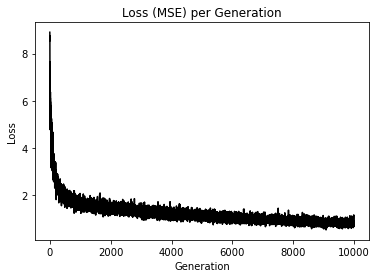

In [64]:
'''
plot the loss over the model training
'''
plt.plot(loss_vec, 'k-', label='Loss') 
plt.title('Loss (MSE) per Generation') 
plt.xlabel('Generation') 
plt.ylabel('Loss') 
plt.show()

In [65]:
'''
 To test the model, we need to see how it performs on the 
 test board that we removed from the training set. 
 We are hoping that the model can generalize and predict 
 the optimal index for moving, which will be index number 6.
'''
test_boards = [test_board] 
logits = model.predict(test_boards)
predictions = tf.argmax(logits, 1)
print(predictions)

tf.Tensor([6], shape=(1,), dtype=int64)


In [66]:
def check(board): 
    wins = [[0,1,2], [3,4,5], [6,7,8], [0,3,6], [1,4,7], [2,5,8], [0,4,8], [2,4,6]] 
    for i in range(len(wins)): 
        if  board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==1.: 
            return 1 
        elif board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==-1.: 
            return 1 
    return 0


## III. Play against the AI <a class="anchor" id="Partie3"></a>

In [67]:
game_tracker = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
win_logical = False
num_moves = 0
while not win_logical:
    player_index = input('Input index of your move (0-8): ')
    num_moves += 1
    # Add player move to game
    game_tracker[int(player_index)] = 1.
    
    # Get model's move by first getting all the logits for each index
    [potential_moves] = model(np.array([game_tracker], dtype=float))
    # Now find allowed moves (where game tracker values = 0.0)
    allowed_moves = [ix for ix, x in enumerate(game_tracker) if x == 0.0]
    # Find best move by taking argmax of logits if they are in allowed moves
    model_move = np.argmax([x if ix in allowed_moves else -999.0 for ix, x in enumerate(potential_moves)])
    
    # Add model move to game
    game_tracker[int(model_move)] = -1.
    print('Model has moved')
    print_board(game_tracker)
    # Now check for win or too many moves
    if check(game_tracker) == -1 or num_moves >= 5:
        print('Game Over!')
        win_logical = True
    elif check(game_tracker) == 1:
        print('Congratulations, You won!')
        win_logical = True


Model has moved
 O |   |  
___________
 X |   |  
___________
   |   |  
Model has moved
 O |   |  
___________
 X | X |  
___________
   |   | O
Model has moved
 O |   | O
___________
 X | X | X
___________
   |   | O
Congratulations, You won!
